## Imports

In [26]:
import matplotlib.pyplot as plt

from qiskit import Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

from qiskit.visualization import plot_histogram

import pennylane as qml

from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import math

from tqdm.notebook import tqdm, trange
import pandas as pd
from datetime import datetime
import os

## Model definition

In [27]:
n_shots = 1

device = qml.device('default.qubit', wires=2, shots=n_shots)

In [28]:
@qml.qnode(device)
def circuit(x, parameters):
    #State Preparation
    for i in range(parameters.shape[1]):
        qml.RY(x[i], wires=i)
        qml.RY(x[i], wires=i)
    #Add layers
    for i in range(parameters.shape[0]):
        for j in range(parameters.shape[1]):
            qml.Rot(parameters[i, j, 0], parameters[i, j, 1], parameters[i, j, 2], wires=j)
            #qml.RX(parameters[i, j, 0], wires=j)
            #qml.RY(parameters[i, j, 1], wires=j)
            #qml.RZ(parameters[i, j, 2], wires=j)

        for j in range(parameters.shape[1]):
            qml.CNOT(wires=[0,1])
            qml.CNOT(wires=[1,0])
    #For measurement apply Pauli-Z to first qubit
    return qml.expval(qml.PauliZ(wires=0))

In [29]:
class Model:
    def __init__(self, n_features=2, n_layers=2):
        self.n_features = n_features
        self.n_layers = n_layers
        self.n_params = self.n_layers*self.n_features*3
        self.modelname = "VQC_" + str(datetime.now().month) + str(datetime.now().day) + "_" + str(datetime.now().hour) + str(datetime.now().minute)
 

    def __call__(self, x, parameters, bias):
        return circuit(x, parameters) + bias

    def save(self, parameters, bias):
        os.makedirs("models/", exist_ok=True)
        np.savez("models/" + self.modelname, parameters=parameters, bias=bias)

## Loss Function

In [30]:
def cost(v, model, X, Y):
    out = np.array([model(x, v[0], v[1]) for x in X])
    return loss(Y, out)
    

def loss(y, out):
    return np.mean((y - out)**2)

## Toy Data Generation

In [31]:
n_signal, n_background = 100000, 100000

data_signal = np.random.multivariate_normal([0, 0], [[0.8, -0.6], [-0.6, 0.8]], size=n_signal) + 0.5
data_background = np.random.multivariate_normal([0, 0], [[0.8, 0.6], [0.6, 0.8]], size=n_background) - 0.5



## Load Real Data

In [32]:
n_signal, n_background = 100000, 100000

data_background = pd.read_csv("data/background_small.csv").to_numpy()[:n_background,1:]
data_signal = pd.read_csv("data/signal_small.csv").to_numpy()[:n_signal,1:]

In [33]:
# Normalize

data_total = np.concatenate((data_background, data_signal), axis=0)

data_background = (data_background - np.mean(data_total, axis=0))/np.std(data_total, axis=0)
data_signal = (data_signal - np.mean(data_total, axis=0))/np.std(data_total, axis=0)

## Visualization

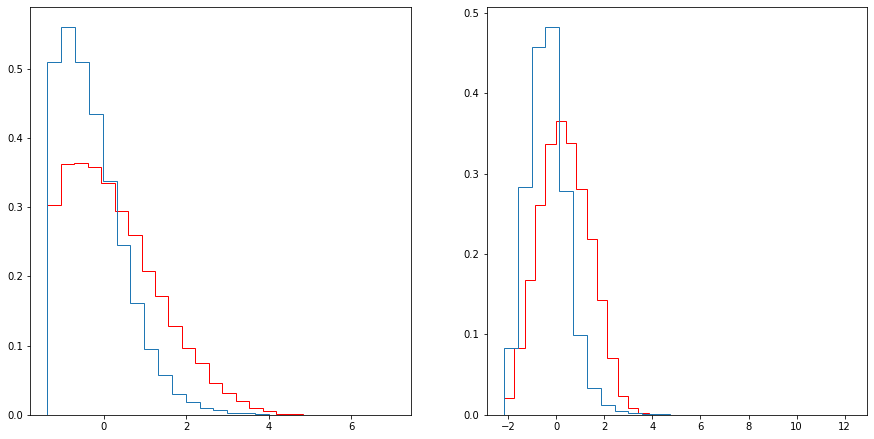

In [34]:
plt.figure(figsize=(15, 7.5))
plt.subplot(1, 2, 1)
plt.hist(data_signal[:,0], bins=25, histtype="step", color="red", density=True)
plt.hist(data_background[:,0], bins=25, histtype="step", density=True)

plt.subplot(1, 2, 2)
plt.hist(data_signal[:,1], bins=25, histtype="step", color="red", density=True)
plt.hist(data_background[:,1], bins=25, histtype="step", density=True)

plt.show()

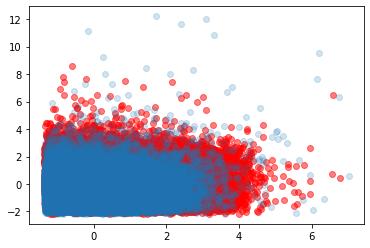

In [35]:
plt.scatter(data_signal[:,0], data_signal[:,1], color="red", alpha=0.5)
plt.scatter(data_background[:,0], data_background[:,1], alpha=0.2)
plt.show()

## Dataloader

In [36]:
test_rat, train_rat = 0.2, 0.8

data_train = np.concatenate([data_signal[:math.ceil(train_rat*len(data_signal))], data_background[:math.ceil(train_rat*len(data_background))]], axis=0)
labels_train = np.concatenate([np.ones(math.ceil(train_rat*len(data_signal))), -np.ones(math.ceil(train_rat*len(data_background)))], axis=0)
data_val = np.concatenate([data_signal[math.ceil(train_rat*len(data_signal)):], data_background[math.ceil(train_rat*len(data_background)):]], axis=0)
labels_val = np.concatenate([np.ones(math.floor(test_rat*len(data_signal))), -np.ones(math.floor(test_rat*len(data_background)))], axis=0)

In [37]:
class Dataloader:
    def __init__(self, data, labels, batchsize):
        assert len(data) == len(labels), "Require the same amount of labels as data"
        self.data = data
        self.labels = labels
        self.bs = batchsize
        
        self.permute()
        self.current = 0
        
    def permute(self):
        perm = np.random.permutation(len(self.data))
        self.data_perm = self.data[perm]
        self.labels_perm = self.labels[perm]
        
    def __len__(self):
        return math.ceil(len(self.data)/self.bs)
        
    def __next__(self):
        if self.current < len(self):
            lower, upper = self.current*self.bs, (self.current+1)*self.bs
            batch = self.data_perm[lower:upper], self.labels_perm[lower:upper]
            self.current += 1
            return batch
        else:
            self.permute()
            raise StopIteration
        
    def __get__(self, ind):
        return data[i], labels[i]
    
    def __iter__(self):
        self.current = 0
        self.permute()
        return self

## Training

In [38]:
# Training Parameters
n_epochs = 5
batch_size = 40
learning_rate = 0.005
beta1, beta2 = 0.9, 0.9


In [39]:
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)
model = Model()

#Initial params
var = (np.random.randn(model.n_layers, model.n_features, 3) * 0.01, 0.0)
trainloader = Dataloader(data_train, labels_train, batch_size)
valloader = Dataloader(data_val, labels_val, batch_size)

In [40]:
def validate(var):
    val_loss = 0
    for x, y in valloader:
        val_loss += cost(var, model, x, y)/len(valloader)
    return val_loss

In [41]:
modeldata = np.load('models/VQC_1017_2030.npz')
var = (modeldata["parameters"], modeldata["bias"])

In [ ]:
for epoch in trange(n_epochs):
    for i, (x, y) in enumerate(tqdm(trainloader, leave=False)):
        var = opt.step(lambda v: cost(v, model, x, y), var)
        if not i % 100:
            model.save(var[0], var[1])
    tqdm.write(f"Validation loss in epoch {epoch}: {validate(var)}")
model.save(var[0], var[1])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

## Validation

In [23]:
# Decision Regions
pixels = np.empty((150, 150))

for i, x in enumerate(np.linspace(-3, 6, 150)):
    for j, y in enumerate(np.linspace(-3, 6, 150)):
        pixels[i, j] = model(np.array([x,y]), var[0], var[1])

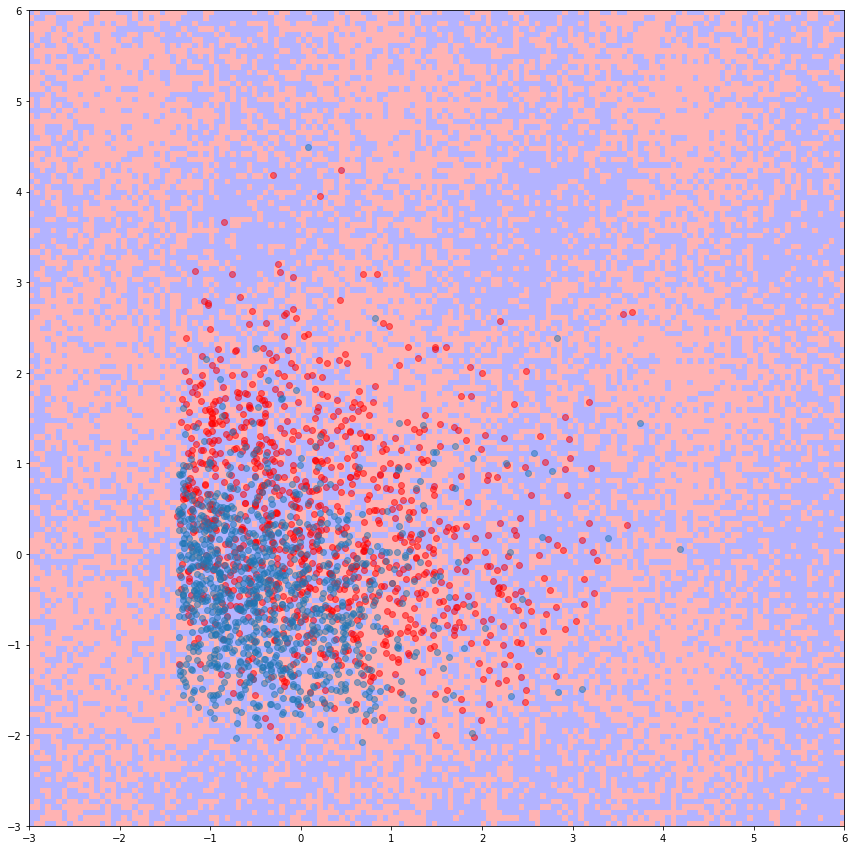

In [24]:
plt.figure(figsize=(15, 15))
plt.imshow(pixels, cmap="bwr", alpha=0.3, extent=[-3, 6, -3, 6])
plt.scatter(data_signal[:1000,0], data_signal[:1000,1], color="red", alpha=0.5)
plt.scatter(data_background[:1000,0], data_background[:1000,1], alpha=0.5)
plt.show()

In [25]:
# Accuracy
acc = 0.0
for x, y in tqdm(valloader):
    out = np.array([model(data, var[0], var[1]) for data in x])
    acc += np.sum(np.sign(y) == np.sign(out))/(len(valloader)*batch_size)
print("Validation accuracy %.2f %%" %(acc*100))

acc = 0.0
for x, y in tqdm(trainloader):
    out = np.array([model(data, var[0], var[1]) for data in x])
    acc += np.sum(np.sign(y) == np.sign(out))/(len(trainloader)*batch_size)
print("Train accuracy %.2f %%" %(acc*100))

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation accuracy 54.13 %


  0%|          | 0/4000 [00:00<?, ?it/s]

KeyboardInterrupt: 